## 引入库

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

In [2]:
data = pd.read_csv('colors.csv')
data.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


In [3]:
names = data['name']

## 数据预处理

In [23]:
maxlen = 25
# 首先将文字处理为以字母为单位的分割形式. 
t = tf.keras.preprocessing.text.Tokenizer(char_level=True)
t.fit_on_texts(names)
# 分词
tokenized = t.texts_to_sequences(names)
# pre 补全
padded_names = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

## 将 RGB 数值从0-255降为 0-1

In [27]:
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data['red']), norm(data['green']), norm(data['blue'])])

## 搭建模型. 输入根据文字处理部分做好. 

In [29]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(0.001), loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 25)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 256)            288768    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 502,787
Trainable params: 502,787
Non-trainable params: 0
_________________________________________________________________


## 添加保存点, 并训练数据

In [30]:
checkpoint_path = "color/{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,period=5)

history = model.fit(padded_names, normalized_values, 
                   epochs=40, 
                   batch_size=32,
                   validation_split=0.1,
                   callbacks=[callback])

Train on 12741 samples, validate on 1416 samples
Epoch 1/40
12741/12741 [==============================] - 4s 324us/step - loss: 0.0631 - val_loss: 0.0636
Epoch 2/40
12741/12741 [==============================] - 3s 196us/step - loss: 0.0593 - val_loss: 0.0613
Epoch 3/40
12741/12741 [==============================] - 3s 205us/step - loss: 0.0572 - val_loss: 0.0602
Epoch 4/40
12741/12741 [==============================] - 3s 227us/step - loss: 0.0554 - val_loss: 0.0597
Epoch 5/40
12640/12741 [============================>.] - ETA: 0s - loss: 0.0537
Epoch 00005: saving model to color/0005.ckpt
12741/12741 [==============================] - 3s 275us/step - loss: 0.0537 - val_loss: 0.0590
Epoch 6/40
12741/12741 [==============================] - 3s 253us/step - loss: 0.0520 - val_loss: 0.0575
Epoch 7/40
12741/12741 [==============================] - 3s 234us/step - loss: 0.0506 - val_loss: 0.0583
Epoch 8/40
12741/12741 [==============================] - 3s 224us/step - loss: 0.0490 - val_l

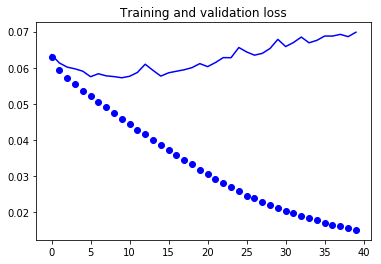

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

In [32]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()
    
def scale(n):
    return int(n * 255)

def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    pred = model.predict(np.array(padded))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

sky, R,G,B: 180 211 215


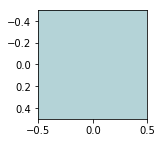

blue, R,G,B: 25 63 208


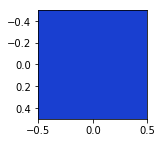

dark blue, R,G,B: 22 54 116


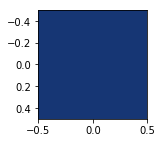

In [33]:
# some "test" data
predict("sky")
predict("blue")
predict("dark blue")

tf orange, R,G,B: 250 198 158


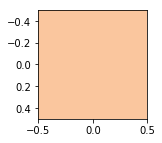

In [49]:
predict("tf orange")